# Emulateur de Feedbacks

Ici on cherche à émuler les PC de EOF de Net Global Feedbacks, à partir des valeurs des paramètres du modèle. 

## Import modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
from smt.sampling_methods import LHS
from pyDOE import *

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
# scatter plot matrix des variables quantitatives
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

## Import functions

In [2]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr
#from Fonctions import pairplot

# Random Forest

## Creation de la Matrices X : valeurs des paramètres

In [3]:
names = ['AKN', 'ALPHAT', 'ALD', 'ALMAVE', 'AGREF', 'AGRE1', 'AGRE2', 'RAUTEFR', 'RQLCR', 
         'RAUTEFS', 'RQICRMIN', 'RQICRMAX', 
         'TFVL', 'TFVI', 'TFVR', 'TFVS', 'RKDN', 'RKDX', 'TENTR', 'TENTRX', 'VVN', 'VVX', 'ALFX', 'FNEBC', 
         'GCTURB', 'RLWINHF_ICE', 'RLWINHF_LIQ', 'RSWINHF_ICE', 'RSWINHF_LIQ', 'REFLCAPE']

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy', names)

In [4]:
param_full_txt = np.loadtxt("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/txt/ENSEMBLE2_LHS500_param_values.txt")
param_full = pd.DataFrame(param_full_txt, columns=names)
param_full

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,VVN,VVX,ALFX,FNEBC,GCTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,REFLCAPE
0,0.252317,1.601128,2.435979,19.416103,-0.036932,5.989398,6.737917,0.007353,0.000653,0.001421,...,-2.111759,-28.844574,0.093100,1.219096,0.000091,0.666159,0.820602,0.944250,0.706469,2.887680
1,0.066290,2.709064,1.844678,15.287098,-0.078563,0.650721,7.469137,0.006073,0.000289,0.008456,...,-1.428366,-42.270705,0.052315,14.818263,0.000050,0.552369,0.610685,0.794383,0.966739,2.248040
2,0.215660,1.777465,1.603821,15.221619,-0.135874,2.119762,4.662149,0.002009,0.000483,0.004937,...,-2.487309,-38.842852,0.049315,7.570708,0.000096,0.814976,0.775567,0.530950,0.509696,5.531803
3,0.274778,1.113779,0.922031,19.030056,-0.118206,0.832389,7.617229,0.001850,0.000636,0.007755,...,-4.589503,-34.810632,0.021196,18.748150,0.000095,0.853328,0.733499,0.895358,0.941681,0.246527
4,0.218043,0.669628,0.967696,13.009419,-0.037687,1.831584,5.781755,0.002399,0.000378,0.009626,...,-4.078592,-28.701539,0.076115,18.773289,0.000013,0.683301,0.538561,0.955131,0.946332,5.628973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.133294,2.055945,1.280783,28.917360,-0.106156,7.270981,5.469558,0.007573,0.000120,0.001870,...,-1.914125,-36.844991,0.065910,8.626037,0.000014,0.625398,0.853473,0.769831,0.910295,4.541277
496,0.197398,1.082317,1.315954,7.337245,-0.090773,2.944683,7.676380,0.001925,0.000899,0.008666,...,-4.746296,-27.759269,0.058793,15.141314,0.000097,0.774480,0.529000,0.871007,0.888378,0.373081
497,0.179710,1.412906,1.575115,18.396143,-0.318467,2.051084,3.109972,0.002554,0.000197,0.009543,...,-1.142406,-46.084322,0.059499,14.160076,0.000065,0.542753,0.851038,0.927384,0.807304,5.384442
498,0.101910,2.069519,2.833468,25.537853,-0.357344,6.771651,0.920854,0.004401,0.000852,0.009070,...,-1.671528,-43.624826,0.092432,4.233910,0.000023,0.517130,0.686721,0.664702,0.934109,5.444576


In [5]:
# Suprimer les lignes qui ont crasher, pour ne garder que les membres disponibles : 


# List avec les outliers : 
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

N=len(nb_p_list)
param = pd.DataFrame(np.array([[1]*30]*N), columns=names)
i = 0
while i<N:
    nb_p = nb_p_list[i]
    nb = int(nb_p.replace("p",""))
    line = nb - 301
    param.iloc[i] = param_full.loc[line]
    i+=1
param

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,VVN,VVX,ALFX,FNEBC,GCTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,REFLCAPE
0,0.217130,2.468936,2.450716,24.812029,-0.154526,1.320257,0.178960,0.007457,0.000330,0.000922,...,-2.830950,-30.837146,0.074744,2.025292,0.000046,0.645691,0.785018,0.740729,0.909344,4.297727
1,0.123071,1.180568,1.399686,11.909834,-0.329893,6.637252,2.157297,0.004761,0.000582,0.006764,...,-1.440143,-25.319285,0.078769,19.731296,0.000022,0.591318,0.904893,0.678563,0.573947,9.620724
2,0.185683,2.104495,0.758250,8.071429,-0.461859,1.942430,1.160540,0.004546,0.000546,0.009574,...,-4.678990,-40.015830,0.022652,5.964623,0.000041,0.505471,0.586978,0.642809,0.964467,9.182342
3,0.146019,2.116275,1.763007,3.304782,-0.299721,4.595020,0.846423,0.003113,0.000961,0.009367,...,-2.501581,-28.424100,0.081760,0.977355,0.000071,0.558995,0.566001,0.592497,0.976976,7.915551
4,0.227225,0.842733,2.037328,17.535065,-0.456922,1.916234,9.663307,0.005922,0.000831,0.009779,...,-4.463783,-47.285216,0.011004,3.438192,0.000086,0.546691,0.685330,0.860116,0.527662,5.167730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.201148,1.033852,0.645775,28.311984,-0.095816,6.246282,3.641144,0.005748,0.000835,0.001060,...,-4.016837,-48.511183,0.079231,7.263262,0.000054,0.905204,0.991032,0.645798,0.569635,9.346306
98,0.127624,0.819273,1.036348,11.616259,-0.219749,7.486118,9.490575,0.005432,0.000298,0.005308,...,-1.694624,-32.907054,0.099305,0.933683,0.000028,0.967330,0.879054,0.667459,0.847306,8.843793
99,0.083406,1.851893,0.780932,11.092776,-0.185707,5.589207,8.547275,0.002676,0.000472,0.006926,...,-1.232495,-25.418422,0.030390,12.393843,0.000049,0.856070,0.959875,0.674130,0.611516,4.195564
100,0.089611,0.771398,0.893933,22.733902,-0.103872,3.236645,3.769349,0.007146,0.000285,0.008785,...,-2.719056,-26.586173,0.043251,19.459661,0.000032,0.881217,0.787925,0.514215,0.809141,5.192041


In [6]:
# normalize data, remove the mean and divide by the standard deviation :
X = param
i=0 
N = len(names)
while i<N:
    name = names[i]
    #print(name)
    mean = param[str(name)].mean() 
    std = param[str(name)].std()
    #print(param[str(name)])
    X[str(name)] = X[str(name)]-mean
    X[str(name)] = X[str(name)]/std
    i=(i+1)
X

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,VVN,VVX,ALFX,FNEBC,GCTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,REFLCAPE
0,0.899023,1.476560,0.988267,1.147542,0.809408,-1.280079,-1.680087,0.936472,-0.812909,-1.438898,...,0.183397,0.719796,0.962956,-1.191676,-0.304117,-0.745492,0.229667,-0.090586,1.119101,-0.322699
1,-0.596517,-0.433720,-0.425945,-0.310489,-0.473866,0.566178,-0.981551,-0.084091,0.115008,0.622718,...,1.384686,1.454941,1.112200,1.742837,-1.249302,-1.110979,1.087520,-0.536020,-1.055544,1.669694
2,0.399015,0.936199,-1.289027,-0.744254,-1.439555,-1.064037,-1.333498,-0.165242,-0.017389,1.614330,...,-1.412820,-0.503079,-0.968638,-0.538789,-0.493542,-1.688023,-1.187547,-0.792209,1.476511,1.505608
3,-0.231635,0.953665,0.062922,-1.282916,-0.253079,-0.142960,-1.444411,-0.707707,1.506940,1.541335,...,0.467885,1.041286,1.223104,-1.365356,0.661025,-1.328249,-1.337666,-1.152710,1.557615,1.031449
4,1.059531,-0.934633,0.432033,0.325198,-1.403426,-1.073134,1.668768,0.355314,1.030432,1.686638,...,-1.226938,-1.471579,-1.400555,-0.957508,1.245406,-1.410952,-0.483722,0.764854,-1.355646,0.002943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.644905,-0.651258,-1.440367,1.543060,1.239030,0.430419,-0.457615,0.289457,1.045002,-1.390153,...,-0.840895,-1.634915,1.129332,-0.323559,0.014438,0.998903,1.703955,-0.770797,-1.083502,1.566979
98,-0.524120,-0.969417,-0.914832,-0.343665,0.332128,0.860935,1.607778,0.170171,-0.932445,0.109067,...,1.164882,0.444023,1.873679,-1.372594,-0.998116,1.416508,0.902613,-0.615584,0.716862,1.378889
99,-1.227192,0.561662,-1.258506,-0.402822,0.581239,0.202258,1.274705,-0.873173,-0.292158,0.679932,...,1.564039,1.441733,-0.681724,0.526760,-0.193802,0.668638,1.480986,-0.567785,-0.811957,-0.360938
100,-1.128537,-1.040402,-1.106459,0.912701,1.180078,-0.614638,-0.412346,0.818703,-0.979835,1.336063,...,0.280044,1.286153,-0.204821,1.697817,-0.844646,0.837672,0.250470,-1.713621,0.469405,0.012042


In [7]:
# Save the numpy array in a file   
X_values=X.values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy', X_values)

## Divide into training and testing dataset

### Global Net Feedbacks

In [25]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS_paramNames.npy")

# split the dataset
X_train = X[0:50,:]
X_test = X[50:,:]
#X_val = X[40:,:]

y_train = y[0:50]
y_test = y[50:]
#y_val = y[40:]

### PC1 - EOF1 : Net Feedbacks

In [130]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/EOF1.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS_paramNames.npy")

# split the dataset
X_train = X[0:40,:]
X_test = X[40:,:]
#X_val = X[40:,:]

y_train = y[0:40]
y_test = y[40:]
#y_val = y[40:]

## Out-Of-Bag error (OOB)

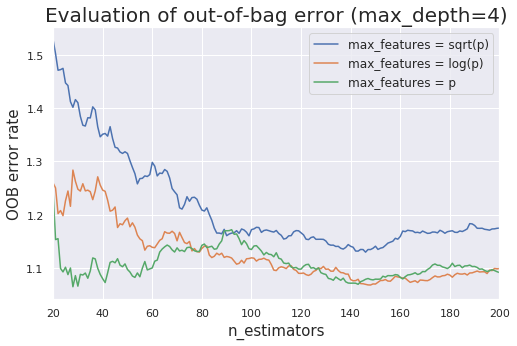

In [131]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("max_features = sqrt(p)",
        RandomForestRegressor(warm_start=True, max_depth=4, oob_score=True,
                               max_features="sqrt")),
    ("max_features = log(p)",
        RandomForestRegressor(warm_start=True, max_depth=4, max_features='log2',
                               oob_score=True)),
    ("max_features = p",
        RandomForestRegressor(warm_start=True, max_depth=4, max_features=None,
                               oob_score=True))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 20
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig, ax = plt.subplots(figsize=(8,5))
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators", fontsize = 15)
plt.ylabel("OOB error rate", fontsize = 15)
plt.legend(loc="upper right", fontsize = 12)
plt.title("Evaluation of out-of-bag error (max_depth=4)", fontsize = 20)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_OOB.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

#Show plot 
plt.show()

## Tuning the hyper-parameters of an estimator

In [132]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# we can loop over the n_estimators for different max_depths to construct Random Forests as follows:

#.................... max_depth=2 ...............

depth=2
skill_score_2=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_2.append(score)
    i = ( i + 1 )


SkillScore_2=pd.DataFrame(skill_score_2)
skill_2 = SkillScore_2.rename(columns={0: 'skill_score'})
#skill_2

#.................... max_depth=4 ...............

depth=4
skill_score_4=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_4.append(score)
    i = ( i + 1 )


SkillScore_4=pd.DataFrame(skill_score_2)
skill_4 = SkillScore_4.rename(columns={0: 'skill_score'})
#skill_4

#.................... max_depth=6 ...............

depth=6
skill_score_6=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_6.append(score)
    i = ( i + 1 )


SkillScore_6=pd.DataFrame(skill_score_2)
skill_6 = SkillScore_6.rename(columns={0: 'skill_score'})
#skill_6

#.................... max_depth=8 ...............

depth=8
skill_score_8=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_8.append(score)
    i = ( i + 1 )


SkillScore_8=pd.DataFrame(skill_score_2)
skill_8 = SkillScore_8.rename(columns={0: 'skill_score'})
#skill_8


## BUILD the SKILL dataframe
skill_sqrt=pd.DataFrame()
skill_sqrt['n_estimators']=range(1,201,1)
skill_sqrt['skill_score_2']=skill_score_2
skill_sqrt['skill_score_4']=skill_score_4
skill_sqrt['skill_score_6']=skill_score_6
skill_sqrt['skill_score_8']=skill_score_8

skill_sqrt

,n_estimators,skill_score_2,skill_score_4,skill_score_6,skill_score_8
0,1,1.573003,1.217147,1.600956,1.546202
1,2,0.901066,1.342318,1.186761,1.168641
2,3,1.032841,1.054835,1.164864,0.927568
3,4,0.630539,0.764866,0.913726,0.984011
4,5,0.873430,0.828550,0.933120,0.926368
...,...,...,...,...,...
195,196,0.766905,0.777656,0.801814,0.774040
196,197,0.796558,0.798473,0.809311,0.777338
197,198,0.756366,0.834844,0.817405,0.799972
198,199,0.758230,0.822604,0.827194,0.786776


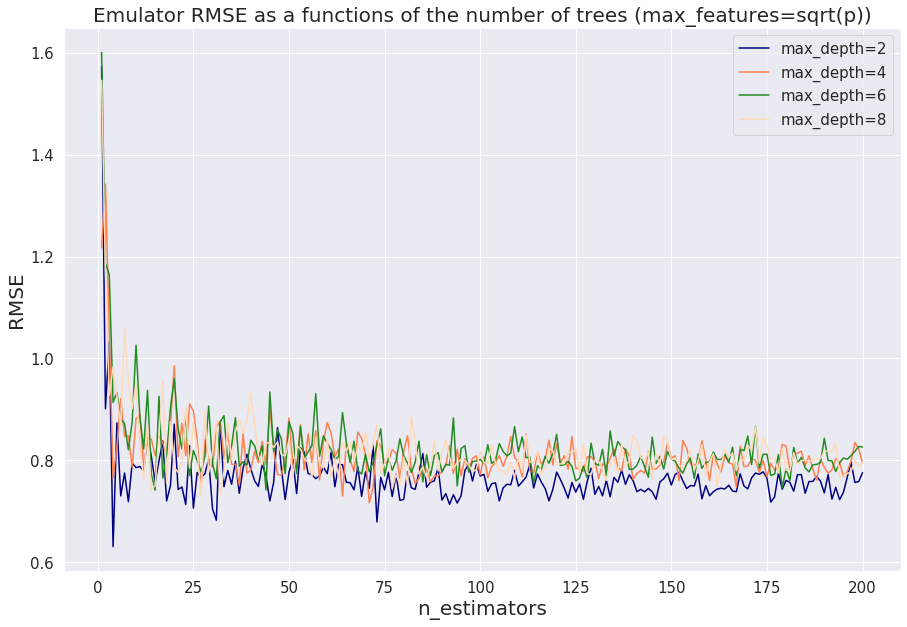

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_estimators", y="skill_score_2", data=skill_sqrt,color='navy',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_4", data=skill_sqrt,color='coral',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_6", data=skill_sqrt,color='forestgreen',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_8", data=skill_sqrt,color='peachpuff',ax=ax)
plt.legend(['max_depth=2','max_depth=4','max_depth=6','max_depth=8'],fontsize=15)
plt.title('Emulator RMSE as a functions of the number of trees (max_features=sqrt(p))',fontsize=20)
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('RMSE',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

#plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_sqrt.png", dpi=None, 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

In [134]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# we can loop over the n_estimators for different max_depths to construct Random Forests as follows:

#.................... max_depth=2 ...............

depth=2
skill_score_2=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_2.append(score)
    i = ( i + 1 )


#SkillScore_2=pd.DataFrame(skill_score_2)
#skill_2 = SkillScore_2.rename(columns={0: 'skill_score'})
#skill_2

#.................... max_depth=4 ...............

depth=4
skill_score_4=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_4.append(score)
    i = ( i + 1 )


#SkillScore_4=pd.DataFrame(skill_score_4)
#skill_4 = SkillScore_4.rename(columns={0: 'skill_score'})
#skill_4

#.................... max_depth=6 ...............

depth=6
skill_score_6=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_6.append(score)
    i = ( i + 1 )


#SkillScore_6=pd.DataFrame(skill_score_2)
#skill_6 = SkillScore_6.rename(columns={0: 'skill_score'})
#skill_6

#.................... max_depth=8 ...............

depth=8
skill_score_8=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_8.append(score)
    i = ( i + 1 )


#SkillScore_8=pd.DataFrame(skill_score_2)
#skill_8 = SkillScore_8.rename(columns={0: 'skill_score'})
#skill_8


## BUILD the SKILL dataframe
skill_log=pd.DataFrame()
skill_log['n_estimators']=range(1,201,1)
skill_log['skill_score_2']=skill_score_2
skill_log['skill_score_4']=skill_score_4
skill_log['skill_score_6']=skill_score_6
skill_log['skill_score_8']=skill_score_8

skill_log

,n_estimators,skill_score_2,skill_score_4,skill_score_6,skill_score_8
0,1,1.007920,1.213791,1.679709,0.856210
1,2,1.055689,0.979910,1.458235,1.048614
2,3,0.818569,1.122425,0.896544,1.006105
3,4,0.839044,1.027471,1.269820,0.881971
4,5,0.910449,0.926906,0.847264,0.938407
...,...,...,...,...,...
195,196,0.744819,0.773253,0.798904,0.776493
196,197,0.733260,0.786092,0.783548,0.789015
197,198,0.716923,0.764538,0.812762,0.776470
198,199,0.716835,0.801874,0.792937,0.781920


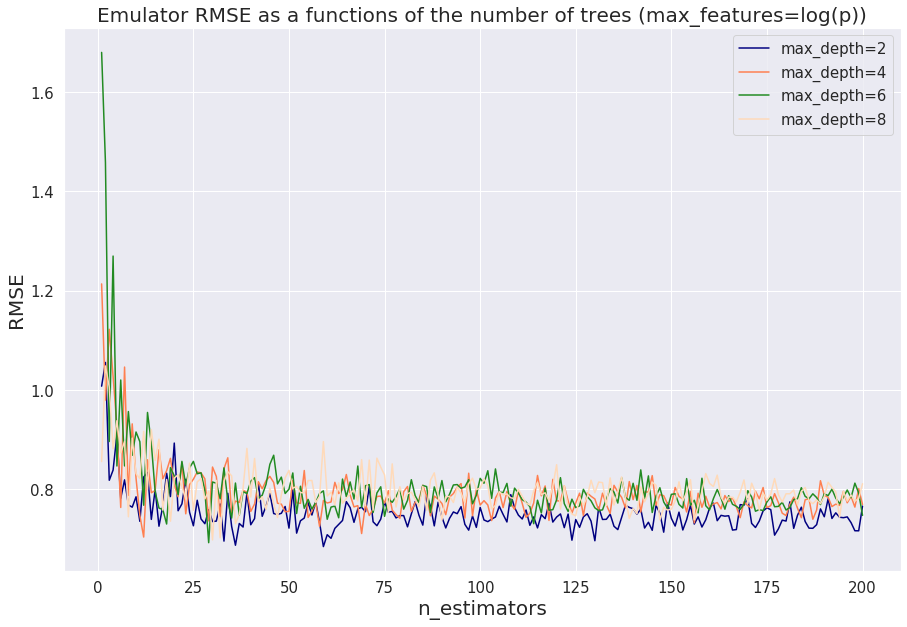

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_estimators", y="skill_score_2", data=skill_log,color='navy',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_4", data=skill_log,color='coral',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_6", data=skill_log,color='forestgreen',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_8", data=skill_log,color='peachpuff',ax=ax)
plt.legend(['max_depth=2','max_depth=4','max_depth=6','max_depth=8'],fontsize=15)
plt.title('Emulator RMSE as a functions of the number of trees (max_features=log(p))',fontsize=20)
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('RMSE',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_log.png", dpi=None, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

In [175]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# we can loop over the n_estimators for different max_depths to construct Random Forests as follows:

#.................... max_depth=2 ...............

depth=2
skill_score_2=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_2.append(score)
    i = ( i + 1 )


#SkillScore_2=pd.DataFrame(skill_score_2)
#skill_2 = SkillScore_2.rename(columns={0: 'skill_score'})
#skill_2

#.................... max_depth=4 ...............

depth=4
skill_score_4=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_4.append(score)
    i = ( i + 1 )


#SkillScore_4=pd.DataFrame(skill_score_2)
#skill_4 = SkillScore_4.rename(columns={0: 'skill_score'})
#skill_4

#.................... max_depth=6 ...............

depth=6
skill_score_6=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_6.append(score)
    i = ( i + 1 )


#SkillScore_6=pd.DataFrame(skill_score_2)
#skill_6 = SkillScore_6.rename(columns={0: 'skill_score'})
#skill_6

#.................... max_depth=8 ...............

depth=8
skill_score_8=[]

i=1
N=201
while i<N: 
    clf = RandomForestRegressor(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score_8.append(score)
    i = ( i + 1 )


#SkillScore_8=pd.DataFrame(skill_score_2)
#skill_8 = SkillScore_8.rename(columns={0: 'skill_score'})
#skill_8

In [176]:
## BUILD the SKILL dataframe
skill_p=pd.DataFrame()
skill_p['n_estimators']=range(1,201,1)
skill_p['skill_score_2']=skill_score_2
skill_p['skill_score_4']=skill_score_4
skill_p['skill_score_6']=skill_score_6
skill_p['skill_score_8']=skill_score_8

skill_p

,n_estimators,skill_score_2,skill_score_4,skill_score_6,skill_score_8
0,1,0.809005,1.115740,2.129270,1.319806
1,2,1.259405,1.334893,1.536605,1.037070
2,3,1.275675,1.796044,1.109493,0.872200
3,4,1.069427,1.168847,1.239971,0.893005
4,5,0.864674,1.036261,0.873227,1.051522
...,...,...,...,...,...
195,196,0.949842,1.028145,1.019801,1.042117
196,197,0.959022,1.020184,1.029334,1.031824
197,198,0.940784,1.035638,1.006580,1.041300
198,199,0.999301,1.005620,1.032522,1.060324


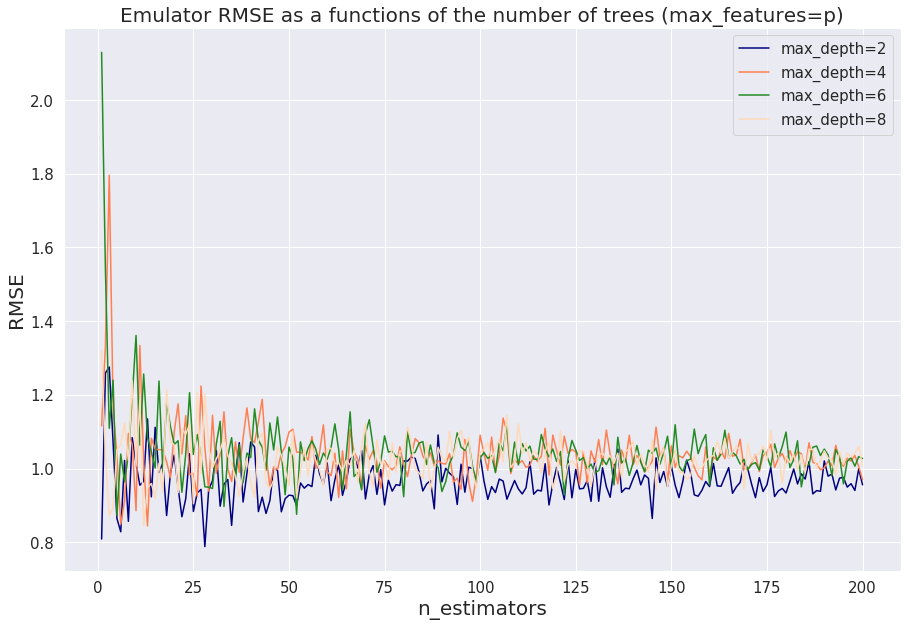

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_estimators", y="skill_score_2", data=skill_p,color='navy',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_4", data=skill_p,color='coral',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_6", data=skill_p,color='forestgreen',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_8", data=skill_p,color='peachpuff',ax=ax)
plt.legend(['max_depth=2','max_depth=4','max_depth=6','max_depth=8'],fontsize=15)
plt.title('Emulator RMSE as a functions of the number of trees (max_features=p)',fontsize=20)
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('RMSE',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_p.png", dpi=None, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

### Cross - validation

In [34]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Set the parameters by cross-validation
tuned_parameters = [{'max_features' : ['sqrt'], 'max_depth': [2,4,6,8,10]},
                    {'max_features' : ['log2'], 'max_depth': [2,4,6,8,10]},
                    {'max_features' : ['auto'], 'max_depth': [2,4,6,8,10]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestRegressor(), tuned_parameters
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
#    y_true, y_pred = y_test, clf.predict(X_test)
#    print(classification_report(y_true, y_pred))
#    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 2, 'max_features': 'sqrt'}

Grid scores on development set:

-0.138 (+/-0.160) for {'max_depth': 2, 'max_features': 'sqrt'}
-0.217 (+/-0.233) for {'max_depth': 4, 'max_features': 'sqrt'}
-0.187 (+/-0.239) for {'max_depth': 6, 'max_features': 'sqrt'}
-0.225 (+/-0.201) for {'max_depth': 8, 'max_features': 'sqrt'}
-0.246 (+/-0.335) for {'max_depth': 10, 'max_features': 'sqrt'}
-0.142 (+/-0.199) for {'max_depth': 2, 'max_features': 'log2'}
-0.225 (+/-0.216) for {'max_depth': 4, 'max_features': 'log2'}
-0.230 (+/-0.218) for {'max_depth': 6, 'max_features': 'log2'}
-0.141 (+/-0.240) for {'max_depth': 8, 'max_features': 'log2'}
-0.248 (+/-0.176) for {'max_depth': 10, 'max_features': 'log2'}
-0.262 (+/-0.263) for {'max_depth': 2, 'max_features': 'auto'}
-0.277 (+/-0.375) for {'max_depth': 4, 'max_features': 'auto'}
-0.287 (+/-0.400) for {'max_depth': 6, 'max_features': 'auto'}
-0.345 (+/-0.378

### Create Random Forest for prediction of Net Global Feedbacks

In [208]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS_paramNames.npy")

# split the dataset
X_train = X[0:45,:]
X_test = X[45:,:]
#X_val = X[40:,:]

y_train = y[0:45]
y_test = y[45:]
#y_val = y[40:]

In [209]:
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# we can construct a Random Forest as follows:

clf_NetFeedbacks = RandomForestRegressor(n_estimators=10,max_depth=4,max_features='auto',bootstrap=True)
clf_NetFeedbacks = clf_NetFeedbacks.fit(X_train,y_train)

In [210]:
# Predict 
y_pred = clf_NetFeedbacks.predict(X_test)
y_pred

array([-1.21257042, -1.43185815, -1.04458524, -1.3642829 , -0.99353309,
       -1.3514133 , -1.36275931, -1.34797216, -1.45093958, -1.38729682,
       -1.39790913, -1.33462487, -1.38726986, -1.33284379, -1.4511441 ,
       -1.35236476, -1.28017989, -1.20673684, -1.42014209, -1.02343395,
       -1.434704  , -1.4268798 , -1.40296776])

In [211]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1785405165989715
Mean Squared Error: 0.048676730655046636
Root Mean Squared Error: 0.22062803687438873


In [212]:
# Create plot 
plot  = pd.DataFrame()
plot['y_pred'] = y_pred
plot['y_test'] = y_test
plot['members'] = range(0,23,1)
plot

,y_pred,y_test,members
0,-1.212570,-1.375376,0
1,-1.431858,-1.478984,1
2,-1.044585,-1.245538,2
3,-1.364283,-1.569354,3
4,-0.993533,-1.309411,4
5,-1.351413,-1.603050,5
6,-1.362759,-1.420873,6
7,-1.347972,-1.577034,7
8,-1.450940,-1.274475,8
9,-1.387297,-1.243327,9


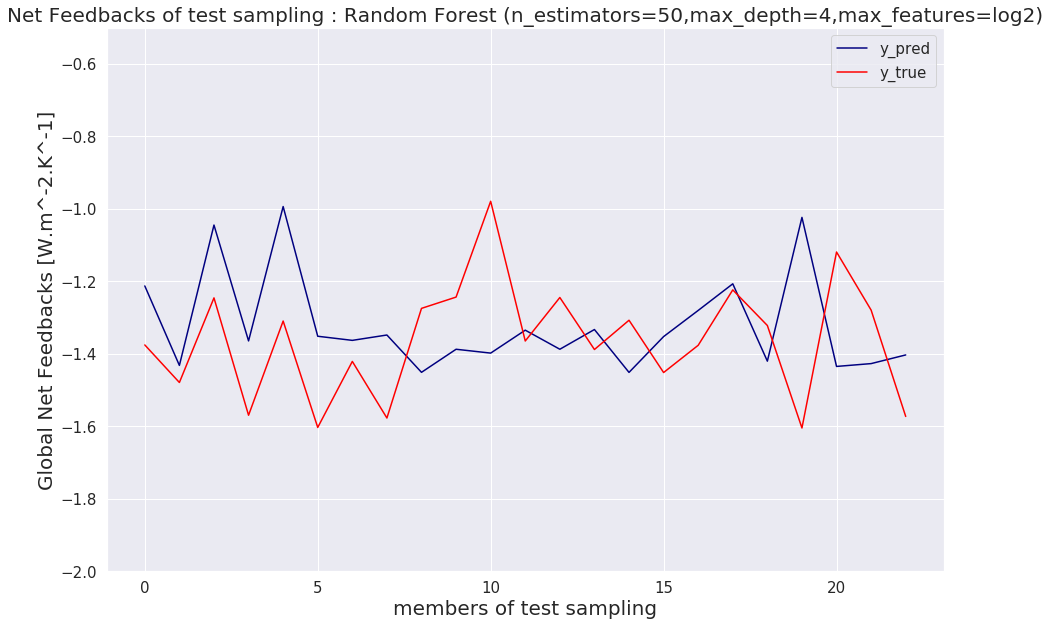

In [213]:
# Plot y_pred and y_test  
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="members", y="y_pred", data=plot,color='navy',ax=ax)
ax = sns.lineplot(x="members", y="y_test", data=plot,color='red',ax=ax)
plt.title('Net Feedbacks of test sampling : Random Forest (n_estimators=50,max_depth=4,max_features=log2)', fontsize=20)
plt.legend(['y_pred','y_true'],fontsize=15)
plt.xlabel('members of test sampling',fontsize=20)
plt.ylabel('Global Net Feedbacks [W.m^-2.K^-1]',fontsize=20)
plt.ylim(-2, -0.5)
ax.tick_params(axis='both', labelsize=15)

### Create Random Forest for the prediction of PC1 (eof1)

In [3]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/EOF1.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS_paramNames.npy")

# split the dataset
X_train = X[0:40,:]
X_test = X[40:,:]
#X_val = X[40:,:]

y_train = y[0:40]
y_test = y[40:]
#y_val = y[40:]

In [4]:
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# we can construct a Random Forest as follows:

clf_pc1 = RandomForestRegressor(n_estimators=20,max_depth=4,max_features='log2',bootstrap=True)
clf_pc1 = clf_pc1.fit(X_train,y_train)

In [5]:
# Predict 
y_pred = clf_pc1.predict(X_test)
y_pred

array([ 0.85934781, -0.30116363,  0.23872471,  0.07908515, -0.11258791,
        0.47672776, -0.42021837, -0.39712292, -0.13051586, -0.06907458,
       -0.22813964, -0.29037943, -0.17914254, -0.41463618, -0.14440559,
       -0.02336613,  0.26731961, -0.24795359,  0.54279097, -0.41736216,
       -0.40134811,  0.11375324, -0.33677901, -0.40149966,  0.48812893,
       -0.05997979,  0.3352683 , -0.39173558])

In [6]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.6111066030943129
Mean Squared Error: 0.5523663891471629
Root Mean Squared Error: 0.7432135555458894


In [7]:
# Create plot 
plot  = pd.DataFrame()
plot['y_pred'] = y_pred
plot['y_test'] = y_test
plot['members'] = range(0,28,1)
plot

,y_pred,y_test,members
0,0.859348,0.524171,0
1,-0.301164,1.348529,1
2,0.238725,-0.492092,2
3,0.079085,0.933662,3
4,-0.112588,0.814469,4
5,0.476728,-0.450336,5
6,-0.420218,-0.652115,6
7,-0.397123,-0.200174,7
8,-0.130516,-0.513463,8
9,-0.069075,-0.153840,9


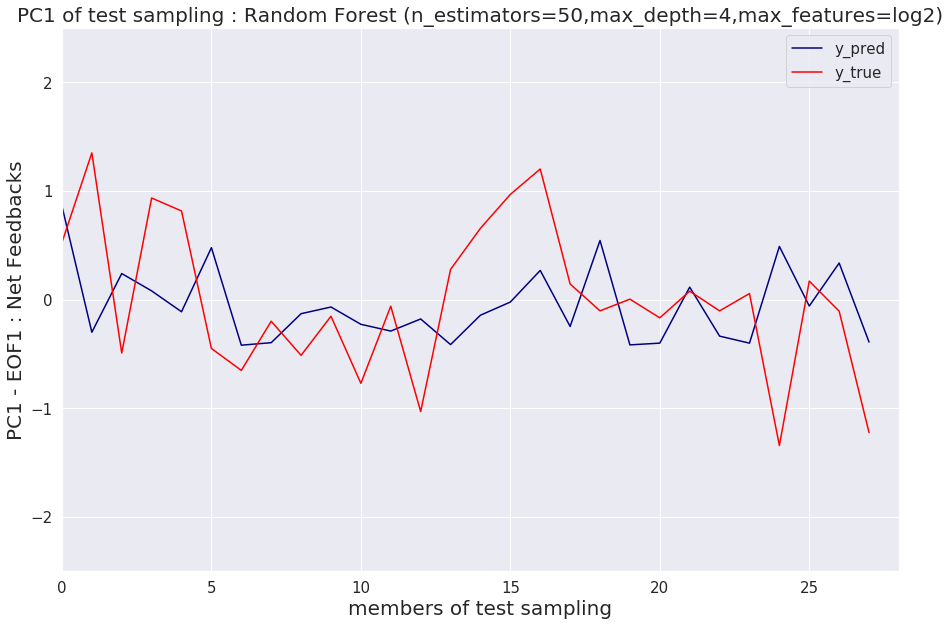

In [8]:
# Plot y_pred and y_test  
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="members", y="y_pred", data=plot,color='navy',ax=ax)
ax = sns.lineplot(x="members", y="y_test", data=plot,color='red',ax=ax)
plt.title('PC1 of test sampling : Random Forest (n_estimators=50,max_depth=4,max_features=log2)', fontsize=20)
plt.legend(['y_pred','y_true'],fontsize=15)
plt.xlabel('members of test sampling',fontsize=20)
plt.ylabel('PC1 - EOF1 : Net Feedbacks',fontsize=20)
plt.ylim(-2.5, 2.5)
plt.xlim(0.0, 28)
ax.tick_params(axis='both', labelsize=15)

### Emulate the LHS 1000

In [262]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS1000_param.npy")
LHS_df = pd.DataFrame(LHS)

lhs = LHS_df.values
lhs

array([[ 1.56517224,  0.99469451, -0.3897521 , ..., -1.12450089,
        -1.34889192, -1.29834626],
       [-0.60785568,  1.0741723 ,  0.93066472, ..., -1.59817485,
        -1.12125895, -0.25278547],
       [ 1.19768897, -1.03400688, -0.00327513, ..., -0.05738016,
        -1.27869833,  0.00395081],
       ...,
       [ 0.0749001 , -0.39621838,  0.94005451, ..., -1.45726925,
         0.73149749, -0.0712116 ],
       [-1.08780342, -1.23068974,  0.7741125 , ..., -0.20982644,
         1.02853718, -0.72898805],
       [ 0.78703615, -1.34662872, -0.4320208 , ..., -0.45074327,
         0.65962055, -0.3646512 ]])

In [263]:
N = clf_NetFeedbacks.predict(lhs)
LHS_N = pd.DataFrame(N, columns=['LHS_N'])
LHS_N

,LHS_N
0,-1.291405
1,-1.239964
2,-1.280952
3,-1.343121
4,-1.378472
...,...
995,-1.390539
996,-1.370017
997,-1.355330
998,-1.412730


In [269]:
EmulateurFeedbacksN_LHS1000_N = LHS_N.values
#Save the numpy array PCs in a file for the Multi Linear Regression   
np.save('/data/home/globc/peatier/CNRMppe/PPE/files/npy/EmulateurFeedbacksN_LHS1000_N.npy', EmulateurFeedbacksN_LHS1000_N)

In [264]:
PC1 = clf_pc1.predict(lhs)
LHS_PC1 = pd.DataFrame(PC1, columns=['LHS_pc1'])
LHS_PC1

,LHS_pc1
0,-0.186128
1,0.229803
2,-0.464739
3,0.487445
4,0.376056
...,...
995,-0.007416
996,0.583905
997,-0.099853
998,0.205442


In [268]:
EmulateurFeedbacksN_LHS1000_pc1 = LHS_PC1.values
#Save the numpy array PCs in a file for the Multi Linear Regression   
np.save('/data/home/globc/peatier/CNRMppe/PPE/files/npy/EmulateurFeedbacksN_LHS1000_pc1.npy', EmulateurFeedbacksN_LHS1000_pc1)

In [265]:
Emulator = pd.concat([LHS_N, LHS_PC1], axis=1)
Emulator

,LHS_N,LHS_pc1
0,-1.291405,-0.186128
1,-1.239964,0.229803
2,-1.280952,-0.464739
3,-1.343121,0.487445
4,-1.378472,0.376056
...,...,...
995,-1.390539,-0.007416
996,-1.370017,0.583905
997,-1.355330,-0.099853
998,-1.412730,0.205442


In [266]:
N = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")
pc1 = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/EOF1.npy")

PPE = pd.DataFrame(N, columns=['N'])
PPE['pc1'] = pc1

PPE

,N,pc1
0,-0.789073,3.377311
1,-1.666454,-1.492581
2,-1.214114,0.696369
3,-1.292415,-0.518312
4,-0.756525,3.185346
...,...,...
63,-1.321747,0.054948
64,-1.604550,-1.343476
65,-1.118935,0.169287
66,-1.279246,-0.107670


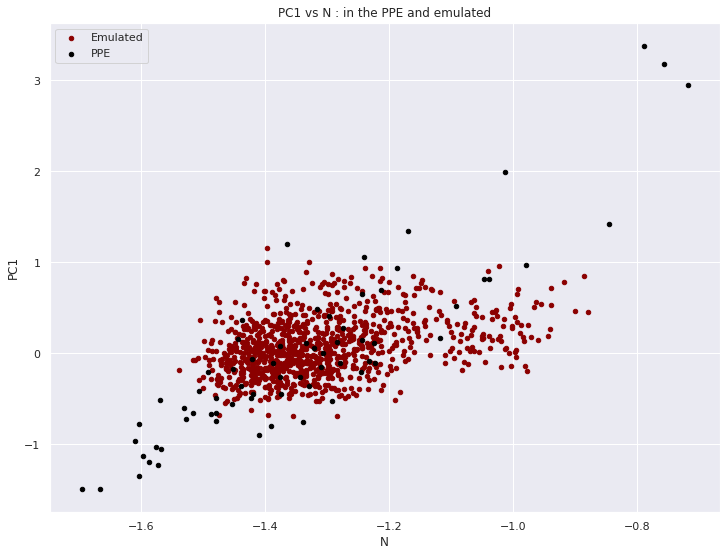

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#print('Coefficient of determination: %.2f'
#      % r2_score(X_test, y_pred))

ax = plt.gca()
title = 'PC1 vs N : in the PPE and emulated'
Emulator.plot(kind='scatter', x='LHS_N', y='LHS_pc1', color='darkred', figsize=(10, 7), 
                     style='.', ax = ax)
PPE.plot(kind='scatter', x='N', y= 'pc1', color='black', figsize=(12, 9), 
                     style='.', ax = ax)
#plt.plot(X_test, y_pred_lasso, color='blue', linewidth=1.0)

plt.xlabel('N')
plt.ylabel('PC1')
plt.title(title)
plt.legend(['Emulated','PPE'])
#plt.xlim(0.000001, 0.000011)
#plt.ylim(-100, 100)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/PPE_Lasso_12.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()